# *Reality Mining: Sensing Social Complex Systems*

*In this paper we describe how data collected from mobile phones can be used to uncover regular rules and structure in the behavior of both individuals and organizations.*

In [104]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sc
import networkx as nx
import glob, os

from sklearn.mixture import GaussianMixture
from pandas.plotting import scatter_matrix

from datetime import datetime, timedelta
from collections import Counter

In [105]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['axes.titlesize'] = 28
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 3
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18

width = 7
height = width / 1.618

matplotlib.rcParams['figure.figsize'] = (width, height)

%matplotlib inline

# Constants

Values we'll use throughout this notebook.

## Temporal

This constant is used to change from continuous to discrete time-series. This change is required for the computations we are going to perform in this exercise.

## Spatial

Similarly, to work with our spatial data and obfuscate the identity and privacy of subjects, we bin our spatial points. This binning is done using a mesh grid with cells equally spaced into `small` (250 meters) and `large` (1 km), 

**Small**
<img src="figures/map_small.png" alt="Drawing" style="width: 800px;"/>

**Large**
<img src="figures/map_large.png" alt="Drawing" style="width: 800px;"/>

In [106]:
# Temporal
## 3600 seconds --> 1 hour
## 1800 seconds --> 1/2 hour
## 900  seconds --> 15 minutes
time_window = 3600

In [107]:
# Spatial cell size for aggregating points

## Small: 250 meters --> locations_small
#spatial_const = 'locations_small'

## Large: 1 km       --> locations_large
spatial_const = 'locations_small'

Convert timestamps into date format

1. Unix epoch into datetime
2. Set all timestamps to CET

Note that all points outside Central Europe will have wrong times, but for (almost) all analysis we are running here this will affect the final results.

In [1]:
input_files_path = glob.glob('*hashed*gz')

all_df = dict()
for fpath in input_files_path:
    print(fpath)
    name = '_'.join(os.path.basename(fpath).split('_')[:-1])
    df_ = pd.read_csv(fpath)
    df_['ts'] = pd.to_datetime(df_.timestamp, unit='ms', utc=True) \
                                .dt.tz_convert('Europe/Berlin') \
                                .dt.round('{}s'.format(time_window))
    # drop users with too few records
    df_clean = df_.groupby(['id']).filter(lambda x: x.ts.nunique() > 10)
    all_df[name] = df_clean

NameError: name 'glob' is not defined

In [109]:
all_df.keys()

dict_keys(['bluetooth', 'wifi', 'sensor_wifi', 'locations_small', 'gsm_neighbor', 'locations_large'])

# Entropy

Entropy is probably the most fundamental quantity capturing the degree of predictability characterizing a time series. The following explanation was taken from the refered paper:

> In information theory, the amount of randomness in a signal corresponds to its entropy, as defined in 1938 by Claude Shannon in the equation below.
>
> $$H(x) = - \displaystyle\sum_{i=1}^{n}p(i)\log_2p(i)$$
>
> For a more concrete example, consider the problem of image compression (such as the jpeg standard) of an overhead photo taken of just an empty checkerboard. This image (in theory) can be significantly compressed because it does not contain much ‘information’. Essen- tially the entire image could be recreated with the same, simple pattern. However, if the picture was taken during the middle of a match, the pieces on the board introduce more randomness into the image and therefore it will prove to be a larger file because it contains more infor- mation, or entropy.

We begin by calculating the value of **entropy** for all input data collected.

In [110]:
sensor_wifi_entropy = all_df['sensor_wifi'].groupby(['id','ts','hashed_sensor_wifi']).timestamp.count().rename('count').reset_index()\
    .pipe(lambda df: df[df['count'] == df.groupby(['id','ts'])['count'].transform(max)])\
    .groupby(['ts','id']).first().reset_index()\
    .groupby(['id','hashed_sensor_wifi']).ts.count()\
    .groupby(level=0).apply(list)\
    .apply(sc.stats.entropy, base=2)

In [111]:
wifi_entropy = all_df['wifi'].groupby(['id','ts','hashed_wifi']).timestamp.count().rename('count').reset_index()\
    .pipe(lambda df: df[df['count'] == df.groupby(['id','ts'])['count'].transform(max)])\
    .groupby(['ts','id']).first().reset_index()\
    .groupby(['id','hashed_wifi']).ts.count()\
    .groupby(level=0).apply(list)\
    .apply(sc.stats.entropy, base=2)

In [112]:
bt_entropy = all_df['bluetooth'].groupby(['id','ts','hashed_bt']).timestamp.count().rename('count').reset_index()\
    .pipe(lambda df: df[df['count'] == df.groupby(['id','ts'])['count'].transform(max)])\
    .groupby(['ts','id']).first().reset_index()\
    .groupby(['id','hashed_bt']).ts.count()\
    .groupby(level=0).apply(list)\
    .apply(sc.stats.entropy, base=2)

In [113]:
locations_small_entropy = all_df['locations_small'].groupby(['id','ts','hashed_locations']).timestamp.count().rename('count').reset_index()\
    .pipe(lambda df: df[df['count'] == df.groupby(['id','ts'])['count'].transform(max)])\
    .groupby(['ts','id']).first().reset_index()\
    .groupby(['id','hashed_locations']).ts.count()\
    .groupby(level=0).apply(list)\
    .apply(sc.stats.entropy, base=2)

In [114]:
locations_large_entropy = all_df['locations_large'].groupby(['id','ts','hashed_locations']).timestamp.count().rename('count').reset_index()\
    .pipe(lambda df: df[df['count'] == df.groupby(['id','ts'])['count'].transform(max)])\
    .groupby(['ts','id']).first().reset_index()\
    .groupby(['id','hashed_locations']).ts.count()\
    .groupby(level=0).apply(list)\
    .apply(sc.stats.entropy, base=2)

In [115]:
data2plot = pd.concat([sensor_wifi_entropy.rename('SW'),
                       wifi_entropy.rename('WF'),
                       bt_entropy.rename('BT'),
                       locations_small_entropy.rename('LS'),
                       locations_large_entropy.rename('LL')],axis=1)

For each time step:

* **SW**: WiFi access points the phone was connected to
* **WF**: neighboring WiFi access point most observed
* **BT**: neighboring Bluetooh device most observed
* **LS**: most visited location (using a **Small** spatial step)
* **LL**: most visited location (using a **Large** spatial step)

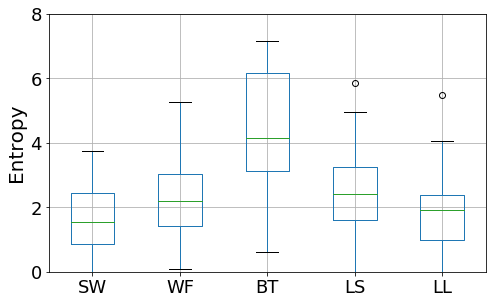

In [116]:
fig,ax = plt.subplots(figsize=(width, height))

data2plot.boxplot(ax=ax)

ax.set_ylim(0,8)
ax.set_ylabel('Entropy')

plt.tight_layout()

# QUESTION 1

Compute the correlation matrix of these values and discuss the results you see:

In [117]:
data2plot.corr()
# LS and LL correlate with each other the best because they are both related to location
# and regardless of step, there is a probability that they have the same value
# the differences between correlations of LS with SW, WF, BT and correlations of LL with SW, WF, BT are
# somehow small because again LS and LL are similar
# corrrelation of SW and WF are larger than correlation of SW and BT
# because connected WiFi and neighboring WiFis might be close to each other
# but devices with BT may vary much (people can pass by)

,SW,WF,BT,LS,LL
SW,1.000000,0.348918,0.287178,0.793631,0.813507
WF,0.348918,1.000000,-0.242567,0.230131,0.207682
BT,0.287178,-0.242567,1.000000,0.486565,0.510805
LS,0.793631,0.230131,0.486565,1.000000,0.944003
LL,0.813507,0.207682,0.510805,0.944003,1.000000


# Question 2

Based on the following plots of users' daily mobility patterns, discuss what differences you see. We compare the daily activities of two different subjects:

* One with a low entropy
* One with a much higher entropy

In [118]:
def idxquantile(s, q=0.5, *args, **kwargs):
    qv = s.quantile(q, *args, **kwargs)
    return (s.sort_values()[::-1] <= qv).idxmax()

In [119]:
# you can play around with these quantile numbers
low_entropy_id = idxquantile(data2plot['LL'], q=0.25)
highest_entropy_id = idxquantile(data2plot['LL'], q=0.98)

In [120]:
lowest_entropy_traces = all_df['locations_large'].groupby(['id','ts','hashed_locations']).timestamp.count().rename('count').reset_index()\
    .pipe(lambda df: df[df['count'] == df.groupby(['id','ts'])['count'].transform(max)])\
    .groupby(['ts','id']).first().reset_index()\
    .pipe(lambda df: df[df.id == low_entropy_id])\
    .assign(hour=lambda df: df.ts.dt.time).assign(day=lambda df: df.ts.dt.dayofyear - df.ts.dt.dayofyear.min())\
    .set_index(['day','hour'])['hashed_locations'].unstack(level=1).fillna('NaN')

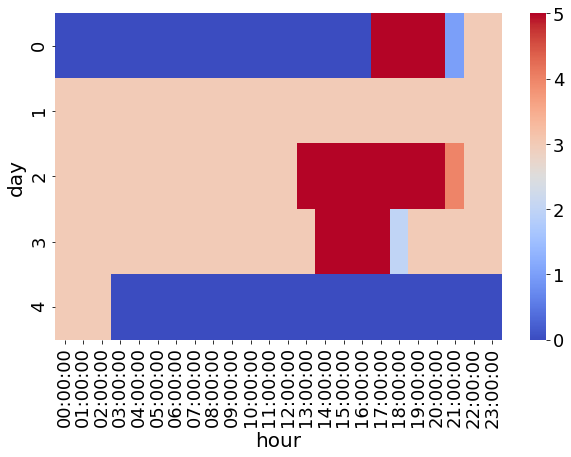

In [121]:
fig,ax = plt.subplots(figsize=(10,6))

cmap = matplotlib.cm.coolwarm
sns.heatmap(lowest_entropy_traces.replace({v:i for i,v in enumerate(set(tt for t in lowest_entropy_traces.values for tt in t))}),ax=ax,cmap=cmap)

In [122]:
highest_entropy_traces = all_df['locations_large'].groupby(['id','ts','hashed_locations']).timestamp.count().rename('count').reset_index()\
    .pipe(lambda df: df[df['count'] == df.groupby(['id','ts'])['count'].transform(max)])\
    .groupby(['ts','id']).first().reset_index()\
    .pipe(lambda df: df[df.id == highest_entropy_id])\
    .assign(hour=lambda df: df.ts.dt.time).assign(day=lambda df: df.ts.dt.dayofyear - df.ts.dt.dayofyear.min())\
    .set_index(['day','hour'])['hashed_locations'].unstack(level=1).fillna('NaN')

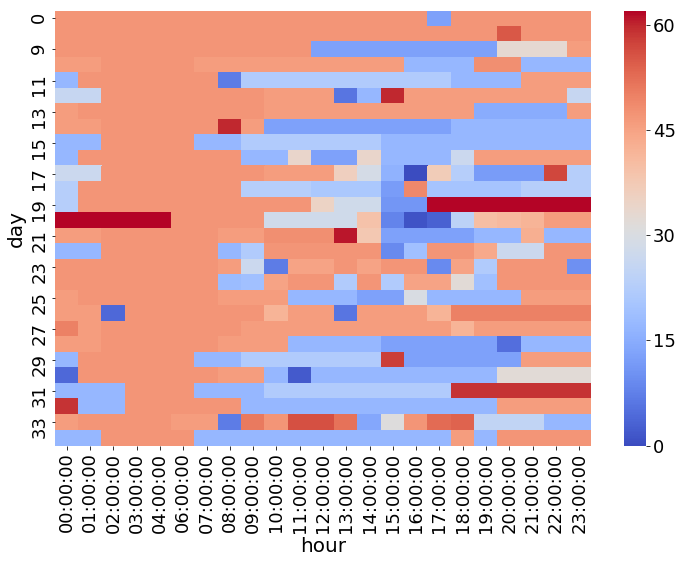

In [155]:
fig,ax = plt.subplots(figsize=(12,8))

cmap = matplotlib.cm.coolwarm
sns.heatmap(highest_entropy_traces\
                .replace({v:i for i,v in enumerate(set(tt for t in highest_entropy_traces.values for tt in t))}),
            ax=ax, cmap=cmap)
# first user was in 5 in one whole day and most night hours so it should be his home
# then he went to light blue areas somehow regularly in afternoons
# second user was in one light blue area in most night hours so it should be his home
# but then unlike first user, he went to very different places during all days
# he was never at home for one whole day, he is very active

# Friends Network

The following is the network of students as answered in the survey.

In [124]:
friends = pd.read_csv('base_social_graph_df.csv', index_col=0)

In [125]:
G = nx.from_numpy_matrix(friends.values)

In [126]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
pos = nx.spring_layout(G, k=1/1.2)

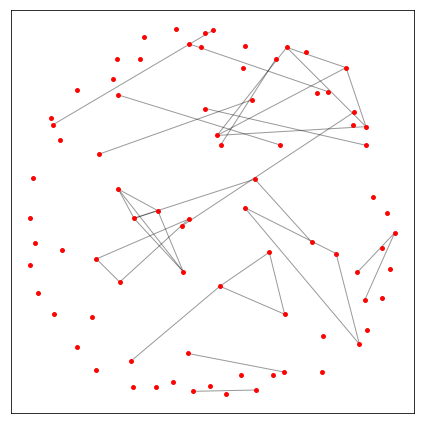

In [127]:
fig,ax = plt.subplots(figsize=(6,6))

nx.draw_networkx_nodes(G, pos, node_size=15, ax=ax)
nx.draw_networkx_edges(G, pos, alpha=0.4, ax=ax)

ax.set_yticks([])
ax.set_xticks([]);

plt.tight_layout()

# Inferred Friends Network via Gaussian Mixture Model

Inferring community structure with the GMM from the sensors data.

## Features computation

* Total proximity
* Weekend proximity
* Evening weekday proximity
* GSM proximity (similar nearby cell towers)
* Bluetooth proximity (similar nearby bluetooth devices)
* WiFi proximity (similar nearby WiFi APs)
* Sensor WiFi proximity (similar WiFi APs the devices were connected during a given time)

In [128]:
def get_proximity_matrix(df):
    proximity_matrix = dict()
    for i,row_vi in df.iteritems():
        proximity_matrix[i] = dict()
        for j,row_vj in df.iteritems():
            if i==j:
                proximity_matrix[i][j] = 0.
            else:
                proximity_matrix[i][j] = len(row_vi & row_vj)
    return proximity_matrix

### Total Proximity

In [129]:
uid_loc_ts = all_df[spatial_const].groupby(['id','ts','hashed_locations']).timestamp.count().rename('count').reset_index()\
    .pipe(lambda df: df[df['count'] == df.groupby(['id','ts'])['count'].transform(max)])\
    .groupby(['ts','id']).first().reset_index()\
    .assign(tl=lambda df: df.apply(lambda x: tuple([x.ts, x.hashed_locations]),axis=1))\
    .groupby('id').tl.apply(set)

In [130]:
total_proximity = pd.DataFrame(get_proximity_matrix(uid_loc_ts))

### Weekend Proximity

In [131]:
uid_loc_ts_we = all_df[spatial_const][((all_df[spatial_const].ts.dt.dayofweek==4)&(all_df[spatial_const].ts.dt.hour>=18))|\
                                          (all_df[spatial_const].ts.dt.dayofweek>4)].groupby(['id','ts','hashed_locations']).timestamp.count().rename('count').reset_index()\
    .pipe(lambda df: df[df['count'] == df.groupby(['id','ts'])['count'].transform(max)])\
    .groupby(['ts','id']).first().reset_index()\
    .assign(tl=lambda df: df.apply(lambda x: tuple([x.ts, x.hashed_locations]),axis=1))\
    .groupby('id').tl.apply(set)

In [132]:
weekend_proximity = pd.DataFrame(get_proximity_matrix(uid_loc_ts_we))

### Evening Proximity

In [133]:
uid_loc_ts_ev = all_df[spatial_const][((all_df[spatial_const].ts.dt.dayofweek<=4)&((all_df[spatial_const].ts.dt.hour>18)|(all_df[spatial_const].ts.dt.hour<7)))]\
    .groupby(['id','ts','hashed_locations']).timestamp.count().rename('count').reset_index()\
    .pipe(lambda df: df[df['count'] == df.groupby(['id','ts'])['count'].transform(max)])\
    .groupby(['ts','id']).first().reset_index()\
    .assign(tl=lambda df: df.apply(lambda x: tuple([x.ts, x.hashed_locations]),axis=1))\
    .groupby('id').tl.apply(set)

In [134]:
evening_proximity = pd.DataFrame(get_proximity_matrix(uid_loc_ts_ev))

### GSM Proximity

In [135]:
uid_gsm_ts = all_df['gsm_neighbor'][['id','ts','hashed_gsm_neighbor']].drop_duplicates()\
    .assign(tl=lambda df: df.apply(lambda x: tuple([x.ts, x.hashed_gsm_neighbor]),axis=1))\
    .groupby('id').tl.apply(set)

In [136]:
gsm_proximity = pd.DataFrame(get_proximity_matrix(uid_gsm_ts))

### Bluetooth Proximity

In [137]:
uid_bt_ts = all_df['bluetooth'][['id','ts','hashed_bt']].drop_duplicates()\
    .assign(tl=lambda df: df.apply(lambda x: tuple([x.ts, x.hashed_bt]),axis=1))\
    .groupby('id').tl.apply(set)

In [138]:
bt_proximity = pd.DataFrame(get_proximity_matrix(uid_bt_ts))

### WiFi

In [139]:
uid_wifi_ts = all_df['wifi'][['id','ts','hashed_wifi']].drop_duplicates()\
    .assign(tl=lambda df: df.apply(lambda x: tuple([x.ts, x.hashed_wifi]),axis=1))\
    .groupby('id').tl.apply(set)

In [140]:
wifi_proximity = pd.DataFrame(get_proximity_matrix(uid_wifi_ts))

### WiFi Sensor

Remember: WiFi Sensor contains information about the AP's the phone was actually connected to.

In [141]:
uid_ws_ts = all_df['sensor_wifi']\
    .groupby(['id','ts','hashed_sensor_wifi']).timestamp.count().rename('count').reset_index()\
    .pipe(lambda df: df[df['count'] == df.groupby(['id','ts'])['count'].transform(max)])\
    .groupby(['ts','id']).first().reset_index()\
    .assign(tl=lambda df: df.apply(lambda x: tuple([x.ts, x.hashed_sensor_wifi]),axis=1))\
    .groupby('id').tl.apply(set)

In [142]:
sensor_wifi_proximity = pd.DataFrame(get_proximity_matrix(uid_ws_ts))

# Gaussian Mixture Model

From the `scikit-learn` page [http://scikit-learn.org/stable/modules/mixture.html]:

> A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

We now compute the set of features used to infer their friendships using a GMM.

In [143]:
all_proximity = (total_proximity, weekend_proximity, evening_proximity, gsm_proximity,
 bt_proximity, wifi_proximity, sensor_wifi_proximity)

In [144]:
all_ids_ = tuple(set(total_proximity.index) | set(weekend_proximity.index) | set(evening_proximity.index) |\
set(gsm_proximity.index) | set(bt_proximity.index) | set(wifi_proximity.index) | set(sensor_wifi_proximity.index))

In [145]:
friends.columns = [int(i) for i in friends.columns]

In [146]:
friends = friends.reindex(index=all_ids_, columns=all_ids_)

In [147]:
total_proximity = total_proximity.reindex(index=all_ids_, columns=all_ids_).fillna(0.)
weekend_proximity = weekend_proximity.reindex(index=all_ids_, columns=all_ids_).fillna(0.)
evening_proximity = evening_proximity.reindex(index=all_ids_, columns=all_ids_).fillna(0.)
gsm_proximity = gsm_proximity.reindex(index=all_ids_, columns=all_ids_).fillna(0.)
bt_proximity = bt_proximity.reindex(index=all_ids_, columns=all_ids_).fillna(0.)
wifi_proximity = wifi_proximity.reindex(index=all_ids_, columns=all_ids_).fillna(0.)
sensor_wifi_proximity = sensor_wifi_proximity.reindex(index=all_ids_, columns=all_ids_).fillna(0.)

#### Unsupervised

In [148]:
model = GaussianMixture(2, max_iter=1000)

In [149]:
for uid in all_ids_:
    X = pd.concat([total_proximity[uid].rename('total'),
                    weekend_proximity[uid].rename('weeekend'),
                    evening_proximity[uid].rename('evening'),
                    gsm_proximity[uid].rename('gsm'),
                    bt_proximity[uid].rename('bt'),
                    wifi_proximity[uid].rename('wifi'),
                    sensor_wifi_proximity[uid].rename('swifi')],axis=1)
    _ = model.fit(X.values)

In [150]:
predict_uid = dict()
for uid in all_ids_:
    X = pd.concat([total_proximity[uid].rename('total'),
                    weekend_proximity[uid].rename('weeekend'),
                    evening_proximity[uid].rename('evening'),
                    gsm_proximity[uid].rename('gsm'),
                    bt_proximity[uid].rename('bt'),
                    wifi_proximity[uid].rename('wifi'),
                    sensor_wifi_proximity[uid].rename('swifi')],axis=1)
    y = friends.loc[uid].rename('friendship').replace({2.:0}).replace({0:False, 1:True}).values
    not_friend = Counter(model.predict(X)).most_common()[0][0]

    prediction_ = model.predict(X) != not_friend
    predict_uid[uid] = prediction_
    acc = (prediction_ == y)
    
    print('UID: {} - Accuracy: {}'.format(uid, np.sum(acc)/acc.size))

UID: 2 - Accuracy: 0.5652173913043478
UID: 10 - Accuracy: 0.8985507246376812
UID: 11 - Accuracy: 0.9130434782608695
UID: 12 - Accuracy: 0.8260869565217391
UID: 13 - Accuracy: 0.9565217391304348
UID: 14 - Accuracy: 0.7246376811594203
UID: 18 - Accuracy: 0.855072463768116
UID: 21 - Accuracy: 0.6811594202898551
UID: 25 - Accuracy: 1.0
UID: 26 - Accuracy: 1.0
UID: 29 - Accuracy: 0.7681159420289855
UID: 30 - Accuracy: 0.6521739130434783
UID: 32 - Accuracy: 1.0
UID: 33 - Accuracy: 0.5217391304347826
UID: 34 - Accuracy: 1.0
UID: 37 - Accuracy: 0.9130434782608695
UID: 38 - Accuracy: 0.6811594202898551
UID: 39 - Accuracy: 0.9420289855072463
UID: 40 - Accuracy: 0.7681159420289855
UID: 41 - Accuracy: 1.0
UID: 44 - Accuracy: 0.9420289855072463
UID: 48 - Accuracy: 1.0
UID: 57 - Accuracy: 0.6666666666666666
UID: 59 - Accuracy: 0.9130434782608695
UID: 60 - Accuracy: 0.927536231884058
UID: 61 - Accuracy: 0.927536231884058
UID: 62 - Accuracy: 0.6811594202898551
UID: 65 - Accuracy: 0.9710144927536232
UI

In [151]:
G_mob = nx.from_numpy_matrix(pd.DataFrame(predict_uid).replace({True:1, False:0}).values)

In [152]:
degree_sequence = sorted((d for n, d in G_mob.degree()), reverse=True)
pos = nx.spring_layout(G_mob, k=1/1.2)

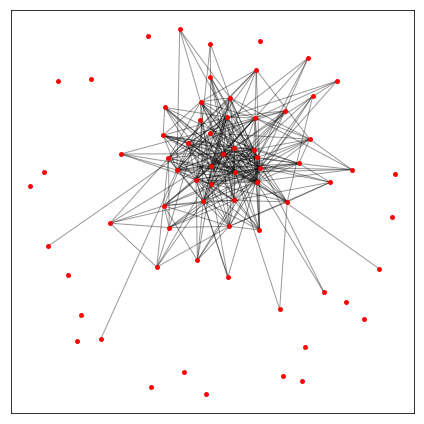

In [153]:
fig,ax = plt.subplots(figsize=(6,6))

nx.draw_networkx_nodes(G_mob, pos, node_size=15, ax=ax)
nx.draw_networkx_edges(G_mob, pos, alpha=0.4, ax=ax)

ax.set_yticks([])
ax.set_xticks([]);

plt.tight_layout()

# Question 3

At "[Constants](#Constants)":

1. Change `time_window` to 30 minutes and 15 minutes.
2. Change `spatial_const` between `large` and `small`.

Re-execute both the entropy and the network inference parts and discuss the differences in the results.

In [154]:
# All executions are compared with 1 hour large
# 1/2 hour large:
# Entropy:
# for first user we can see he spent his nights also in 2 different locations but order is different with the 1 hour time window
# for first user also total places increased (2 times higher than 1 hour time window)
# for second user we can clearly see where he spent most of his time
# for second also total places decreased significantly (from approximately 60 to 20)
# Inference:
# Groups are more homogenous (3 & 4 people instead of 2 & 5 people)
# 1/4 hour large:
# Entropy:
# for first user we can clearly where he spent most of hist time
# for first user also total places increased significantly (8 times higher than 1 hour time window)
# for second user again we can clearly see where he spent most of his time
# for second also total places decreased significantly (from approximately 60 to 20)
# Inference:
# Now this friendship inference began to look complicated. There is just 1 group which is connected,
# covers approximately half of the users and has many intra connections (especially in the center)
# 1 hour small:
# Entropy:
# for both users we have the same results, only the colors of places changes
# Inference:
# This inference looks also complicated. There is just 1 group which is connected
# covers more than half of the users and has much more intra connections (again especially in the center)